In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# PINN model (2D: x,y,t -> u) 
class PINN(nn.Module):
    def __init__(self, width=128, depth=8):
        super().__init__()
        layers = []

        # input (x, y, t) -> R^3
        layers += [nn.Linear(3, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, t):
        X = torch.stack((x, y, t), dim=-1)  
        u = self.net(X)                     
        return u.squeeze(-1)              


def grad(u, x):
    return torch.autograd.grad(
        outputs=u,
        inputs=x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
    )[0]

def laplacian(u, x, y):
    ux = grad(u, x)
    uxx = grad(ux, x)
    uy = grad(u, y)
    uyy = grad(uy, y)
    return uxx + uyy


def residual(model, x, y, t, c, alpha, f_fn):
    # x,y,t must require grad for derivatives
    x = x.detach().requires_grad_(True)
    y = y.detach().requires_grad_(True)
    t = t.detach().requires_grad_(True)

    u = model(x, y, t)
    ut = grad(u, t)
    utt = grad(ut, t)
    lap = laplacian(u, x, y)
    f = f_fn(x, y, t) 
    R = utt - c * lap + alpha * ut - f
    return R, u, ut



def f_fn(x, y, t):
    # zero source by default
    return torch.zeros_like(x)


mse = nn.MSELoss()

def loss_pinn(model,
              x_p, y_p, t_p,          
              x_0, y_0, u0, v0,       
              x_b, y_b, t_b, g,      
              c, alpha, f_fn,
              w_phys=1, w_ic=10, w_bc=10):

    # physics residual
    R, _, _ = residual(model, x_p, y_p, t_p, c, alpha, f_fn)
    L_phys = torch.mean(R**2)

    # initial displacement and velocity at t=0
    t0 = torch.zeros_like(x_0, requires_grad=True)
    u0_pred = model(x_0, y_0, t0)
    L_u0 = mse(u0_pred, u0)

    ut0_pred = grad(u0_pred, t0)
    L_v0 = mse(ut0_pred, v0)

    # boundary (Dirichlet)
    u_b = model(x_b, y_b, t_b)
    L_bc = mse(u_b, g)

    L = w_phys * L_phys + w_ic * (L_u0 + L_v0) + w_bc * L_bc
    return L, L_phys.detach(), (L_u0 + L_v0).detach(), L_bc.detach()


# Training loop function
def train(x_p, y_p, t_p,
          x_0, y_0, u0, v0,
          x_b, y_b, t_b, g,
          c, alpha):
    
    model = PINN(width=128, depth=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    runs = 10000
    for it in range(runs + 1):
        optimizer.zero_grad()
        L, Lp, Lic, Lbc = loss_pinn(
            model,
            x_p, y_p, t_p,
            x_0, y_0, u0, v0,
            x_b, y_b, t_b, g,
            c, alpha, f_fn,
            w_phys=1, w_ic=10, w_bc=10
        )
        L.backward()
        optimizer.step()

        if it % 1000 == 0:
            print(f"{it:05d}  total={L.item():.3e}  phys={Lp.item():.3e}  ic={Lic.item():.3e}  bc={Lbc.item():.3e}")
    return model

In [ ]:
# Limits of the domain
x_min, x_max = -1, 1
y_min, y_max = -1, 1
t_min, t_max =  0, 1

c = torch.tensor(1, device=device)
alpha = torch.tensor(0, device=device)  

# collocation (physics)
N_phys = 2000
x_p = torch.empty(N_phys, device=device).uniform_(x_min, x_max)
y_p = torch.empty(N_phys, device=device).uniform_(y_min, y_max)
t_p = torch.empty(N_phys, device=device).uniform_(t_min, t_max)

# initial condition (t=0)
N_ic = 500
x_0 = torch.empty(N_ic, device=device).uniform_(x_min, x_max)
y_0 = torch.empty(N_ic, device=device).uniform_(y_min, y_max)
u0 = torch.exp(-5 * (x_0**2 + y_0**2))
v0 = torch.zeros_like(x_0)

# boundary 
# Left - Right
N_bc = 500
nb1 = N_bc // 2
t_b1 = torch.empty(nb1, device=device).uniform_(t_min, t_max)
y_b1 = torch.empty(nb1, device=device).uniform_(y_min, y_max)
x_left  = torch.full((nb1 // 2,), x_min, device=device)
x_right = torch.full((nb1 - nb1 // 2,), x_max, device=device)
x_b1 = torch.cat([x_left, x_right], dim=0)

# Top - Bottom
nb2 = N_bc - nb1
t_b2 = torch.empty(nb2, device=device).uniform_(t_min, t_max)
x_b2 = torch.empty(nb2, device=device).uniform_(x_min, x_max)
y_bottom = torch.full((nb2 // 2,), y_min, device=device)
y_top = torch.full((nb2 - nb2 // 2,), y_max, device=device)
y_b2 = torch.cat([y_bottom, y_top], dim=0)

x_b = torch.cat([x_b1, x_b2], dim=0)
y_b = torch.cat([y_b1, y_b2], dim=0)
t_b = torch.cat([t_b1, t_b2], dim=0)
g = torch.zeros_like(x_b)


In [22]:
model = train(x_p, y_p, t_p,
      x_0, y_0, u0, v0,
      x_b, y_b, t_b, g,
      c, alpha)

00000  total=7.694e-01  phys=3.522e-07  ic=7.497e-02  bc=1.972e-03
01000  total=1.241e-02  phys=3.177e-03  ic=4.450e-04  bc=4.784e-04
02000  total=4.239e-03  phys=1.195e-03  ic=1.126e-04  bc=1.917e-04
03000  total=3.933e-03  phys=6.707e-04  ic=1.628e-04  bc=1.635e-04
04000  total=3.078e-03  phys=4.704e-04  ic=1.071e-04  bc=1.536e-04
05000  total=5.911e-03  phys=4.967e-04  ic=2.761e-04  bc=2.654e-04
06000  total=1.966e-03  phys=3.496e-04  ic=4.787e-05  bc=1.138e-04
07000  total=1.638e-03  phys=2.684e-04  ic=3.693e-05  bc=1.001e-04
08000  total=1.512e-03  phys=3.032e-04  ic=3.906e-05  bc=8.180e-05
09000  total=1.393e-03  phys=3.187e-04  ic=4.386e-05  bc=6.359e-05
10000  total=7.414e-04  phys=1.767e-04  ic=1.033e-05  bc=4.614e-05


In [ ]:
# Function to compute reference solution using finite differences (Chat GPT was used to generate this code)
def fd_wave_2d(u0_fn, c, x_min, x_max, y_min, y_max, T, 
               Nx=101, Ny=101, Nt=200):
    """
    Explicit 2D wave solver with 5-point Laplacian, Dirichlet u=0 boundary, v0=0.
    Returns u_fd of shape (Nt, Nx, Ny).
    """
    x = np.linspace(x_min, x_max, Nx)
    y = np.linspace(y_min, y_max, Ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    assert abs(dx - dy) < 1e-12, "use equal spacing for simplicity"
    h = dx

    dt = T / (Nt - 1)
    # CFL stability for 2D wave: c*dt/h <= 1/sqrt(2)
    assert c * dt / h <= 1/np.sqrt(2) + 1e-12, "reduce dt or increase Nt"

    # allocate
    u_fd = np.zeros((Nt, Nx, Ny), dtype=np.float64)

    # initial condition u(x,y,0)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_fd[0] = u0_fn(X, Y)

    # --- one-sided step for n=1 using v0=0 and f=0 ---
    u0 = u_fd[0]
    lap0 = np.zeros_like(u0)
    lap0[1:-1, 1:-1] = (
        u0[2:,   1:-1] +
        u0[0:-2, 1:-1] +
        u0[1:-1, 2:  ] +
        u0[1:-1, 0:-2] -
        4 * u0[1:-1, 1:-1]
    ) / h**2

    u_fd[1] = u_fd[0] + 0.5 * (c * dt)**2 * lap0

    # enforce Dirichlet boundary u=0 at n=0 and n=1
    for n in [0, 1]:
        u_fd[n, 0,   :] = 0
        u_fd[n, -1,  :] = 0
        u_fd[n, :,   0] = 0
        u_fd[n, :,  -1] = 0

    # --- time stepping ---
    for n in range(1, Nt - 1):
        u = u_fd[n]
        u_prev = u_fd[n - 1]

        lap = np.zeros_like(u)
        lap[1:-1, 1:-1] = (
            u[2:,   1:-1] +
            u[0:-2, 1:-1] +
            u[1:-1, 2:  ] +
            u[1:-1, 0:-2] -
            4 * u[1:-1, 1:-1]
        ) / h**2

        u_next = np.zeros_like(u)
        u_next[1:-1, 1:-1] = (
            2 * u[1:-1, 1:-1]
            - u_prev[1:-1, 1:-1]
            + (c * dt)**2 * lap[1:-1, 1:-1]
        )

        # Dirichlet boundary
        u_next[0,   :] = 0
        u_next[-1,  :] = 0
        u_next[:,   0] = 0
        u_next[:,  -1] = 0

        u_fd[n + 1] = u_next

    return x, y, np.linspace(0, T, Nt), u_fd



def u0_fn_np(X, Y):
    return np.exp(-5*(X**2 + Y**2))

c_val = 1
T = 1
x, y, t_grid, u_fd = fd_wave_2d(u0_fn_np, c_val,
                                x_min, x_max, y_min, y_max,
                                T, Nx=101, Ny=101, Nt=201)

In [ ]:
model.eval()

Nx, Ny, Nt = u_fd.shape[1], u_fd.shape[2], u_fd.shape[0] # Number of points in x,y,t

x_torch = torch.tensor(x, dtype=torch.float32, device=device) # Convert to torch tensors
y_torch = torch.tensor(y, dtype=torch.float32, device=device)
X_torch, Y_torch = torch.meshgrid(x_torch, y_torch, indexing='ij')  # Matrices of dimension : (Nx,Ny)

# Evaluate at final time step
k = -1  # last time step
t_val = float(t_grid[k])
T_torch = torch.full_like(X_torch, t_val, dtype=torch.float32, device=device) # Matrix (Nx,Ny) with time t_val

with torch.no_grad():  # Disables gradient computation -> faster
    # Flatten inputs for the model
    x_in = X_torch.reshape(-1)
    y_in = Y_torch.reshape(-1)
    t_in = T_torch.reshape(-1)

    # Reshape output back to grid
    u_pinn_flat = model(x_in, y_in, t_in)
    u_pinn_grid = u_pinn_flat.reshape(Nx, Ny).cpu().numpy()

u_fd_grid = u_fd[k]  # Extract the finite-difference (FD) solution
print("t =", t_val, " L2 error =", np.sqrt(np.mean((u_pinn_grid - u_fd_grid)**2)), "  max error =", np.max(np.abs(u_pinn_grid - u_fd_grid)))

t = 1.0  L2 error = 0.012739665558317364   max error = 0.07347874343395233


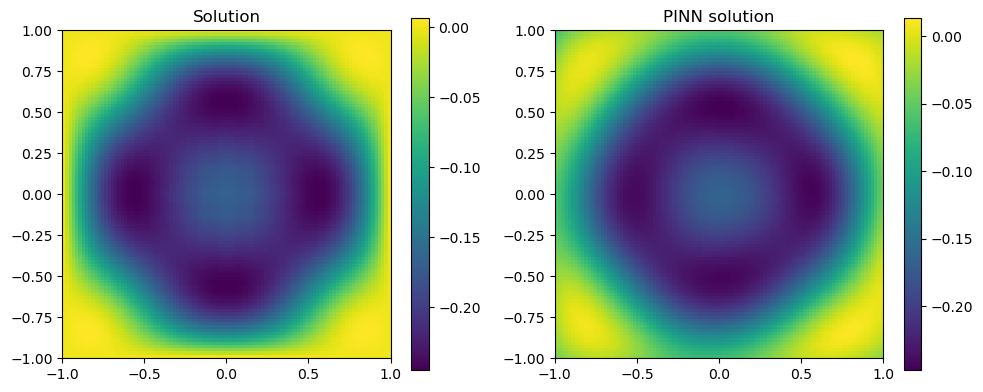

In [ ]:
# Plot solutions (Chat GPT was used to generate this code)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Solution")
plt.imshow(u_fd_grid.T, origin='lower',
           extent=[x_min,x_max,y_min,y_max], aspect='equal')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("PINN solution")
plt.imshow(u_pinn_grid.T, origin='lower',
           extent=[x_min,x_max,y_min,y_max], aspect='equal')
plt.colorbar()

plt.tight_layout()
plt.show()